# Project 05: Forecasting Morphogenesis in Latent and Image Space

Three main classes:
1. **DataModule:** Manages all data loading, processing, and batching.
2. **ForecasterModel:** Defines the PyTorch model architecture.
3. **Trainer:** Handles the training and validation loops.

Initial imports and Setup:

In [1]:
import os
import gdown
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import ssim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Module Class

* Downloading the data.
* Loading and normalizing the .tif stacks.
* Calculating metadata (timestamps) for each frame.
* Plotting the stacks.
* Creating input/output sequences (X, y).
* Splitting data into training and validation sets.
* Creating the final PyTorch DataLoaders.

In [2]:
class DataModule:
    """
    Handles dowloading, loading, processing, plotting, and batching of embryo data
    """
    def __init__(self, folder_id, data_dir="data", t_start=120, t_end=960):
        """
        Initialized the DataModule.
        
        Args:
        folder_id (str): Google Drive folder ID for the data.
        data_dir (str): Local directory to store downloaded data.
        t_start (int): Timestamp of the first frame (in minutes).
        t_end (int): Timestamp of the last frame (in minutes).
        
        Attributes:
        folder_id (str): Google Drive folder ID.
        data_dir (str): Local directory path for data.
        t_start (int): Start time (minutes) mapped to frame 0.
        t_end (int): End time (minutes) mapped to the last frame.
        embryo_files (List[str]): Sorted list of .tif filenames found in data_dir.
        normalized_data (Dict[str, np.ndarray]): Dict mapping embryo name -> normalized stack (N, H, W) in [0,1].
        metadata_timestamps (Dict[str, np.ndarray]): Dict mapping embryo name -> timestamps array (N,) in minutes.
        """
        self.folder_id = folder_id
        self.data_dir = data_dir
        self.t_start = t_start
        self.t_end = t_end
        
        self.embryo_files = []
        self.normalized_data = {}
        self.metadata_timestamps = {}
        
        print(f"DataModule initialized. Data will be stored in '{self.data_dir}'.")
        
    
    def _download_data(self):
        """
        Downloads data from Google Drive if it doesn't already exist.
        """
        if os.path.exists(self.data_dir):
            print(f"Directory '{self.data_dir}' already exists.")
        else:
            os.makedirs(self.data_dir)
            print(f"Created directory '{self.data_dir}'.")
        # If directory is empty, download
        if not os.listdir(self.data_dir):
            url = f"https://drive.google.com/drive/folders/{self.folder_id}"
            gdown.download_folder(url, output=self.data_dir, quiet=False)
            print("Download complete.")
        else:
            print("Data directory is not empty, skipping download.")
        
        self.embryo_files = sorted([f for f in os.listdir(self.data_dir) if f.endswith('.tif')])
        print(f"Found {len(self.embryo_files)} embryo files.")
        

    def _calculate_timestamps(self, num_frames):
        """
        Calculates a linear interpolation of time for each frame.
        
        Args:
        num_frames (int): Number of frames (N) in the stack.

        Returns:
        np.ndarray: Array of shape (N,) with timestamps (in minutes), linearly spaced from frame 0 to frame N-1.

        """
        return np.linspace(self.t_start, self.t_end, num_frames)

    def load_and_process_data(self):
        """
        Loads all TIF files, normalizes them, and calculates timestamps for each embryo.
        """
        self._download_data()
        
        for name in self.embryo_files:
            file_path = os.path.join(self.data_dir, name)
            # Load the stack
            stack = tiff.imread(file_path)
    
            # Normalize the stack (Uint8: max pixel value 255)
            normalized_stack = stack.astype("float32") / 255.0
    
            # Calculate timestamps
            num_frames = len(normalized_stack)
            timestamps = self._calculate_timestamps(num_frames)
            
            # Save in dictionaries
            key_name = name.split('.')[0]
            self.normalized_data[key_name] = normalized_stack
            self.metadata_timestamps[key_name] = timestamps
    
    def visualize_embryo(self, embryo_name):
        """
        Plots the first, middle, and last frames for a given embryo.
        
        Args:
        embryo_name (str): Key name of the embryo stack to visualize.
        """
        if embryo_name not in self.normalized_data:
            print(f"Error: Embryo '{embryo_name}' not found.")
            return

        stack = self.normalized_data[embryo_name]
        timestamps = self.metadata_timestamps[embryo_name]
        # Frames explored
        time_points = [0, len(stack) // 2, len(stack) - 1]
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, tp_index in enumerate(time_points):
            ax = axes[i]
            frame = stack[tp_index]
            timestamp_min = timestamps[tp_index]
            
            ax.imshow(frame, cmap='gray', vmin=0, vmax=1)
            ax.set_title(f"Frame: {tp_index}\nTime: {timestamp_min:.2f} min")
            ax.axis("off")
            
        plt.suptitle(f"Visualization of {embryo_name}", fontsize=16)
        plt.tight_layout()
        plt.show()

    def _create_sequences(self, data_stack, n_past, n_future):
        """
        Creates sliding-window sequences (X, y) from a normalized stack.
        
        Args:
        data_stack (np.ndarray): Array of shape (N, H, W).
        n_past (int): Number of past frames in each input sequence.
        n_future (int): Number of future frames to predict.

        Returns:
        Tuple[np.ndarray, np.ndarray]:
        X_all: Array of shape (n_samples, n_past, H, W)
        y_all: Array of shape (n_samples, n_future, H, W)
        """
        X_list, y_list = [],[]
        total_frames = len(data_stack)

        for i in range(total_frames - n_past - n_future + 1):
            past_start = i
            past_end = past_start + n_past
            future_start = past_end
            future_end = future_start + n_future

            X_seq = data_stack[past_start : past_end]
            y_seq = data_stack[future_start : future_end]
            X_list.append(X_seq)
            y_list.append(y_seq)

        return np.array(X_list), np.array(y_list)

    def prepare_dataloaders(self, target_embryo, n_past, n_future, train_split_percent, batch_size):
        """
        Prepares PyTorch DataLoaders for a single target embryo using a temporal train/val split.
        Args:
        target_embryo (str): Embryo key name to use for training/validation.
        n_past (int): Number of past frames in each input sequence.
        n_future (int): Number of future frames to predict.
        train_split_percent (float): Fraction used for the training partition.
        batch_size (int): Batch size for both train and validation loaders.

        Returns: None. But sets the following attributes:
        self.train_loader
        self.val_loader
        """
        self.target_embryo = target_embryo
        self.n_past = n_past
        self.n_future = n_future
        self.train_split_percent = train_split_percent

        if target_embryo not in self.normalized_data:
            print(f"Error: Target embryo '{target_embryo}' not found.")
            return

        target_stack = self.normalized_data[target_embryo]

        # Create sequences
        X_all_seqs, y_all_seqs = self._create_sequences(target_stack, n_past, n_future)
        total_samples = len(X_all_seqs)
        print(f"Total sequences created: {total_samples}")
        
        # Divide train and validation
        split_index = int(total_samples * train_split_percent)
        print(f"Training sequences: {split_index} ({train_split_percent*100} %)")
        print(f"Validation sequences: {total_samples - split_index} ({np.ceil((1-train_split_percent)*100)} %)")
        X_train = X_all_seqs[:split_index]
        y_train = y_all_seqs[:split_index]
        X_val = X_all_seqs[split_index:]
        y_val = y_all_seqs[split_index:]

        # Reshape for PyTorch (ConvLSTM needs B, T, C, H, W)
        # Original shapes:
        # X: (n_samples, n_past, H, W)
        # y: (n_samples, n_future, H, W)
        
        # Add channel dimension (C)
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        y_train = np.expand_dims(y_train, axis=-1)
        y_val = np.expand_dims(y_val, axis=-1)
        
        # Move channel dimension to correct place (B, T, C, H, W)
        X_train_np = np.moveaxis(X_train, -1, 2)
        X_val_np = np.moveaxis(X_val, -1, 2)
        
        # (n_samples, n_future, H, W, C) -> (n_samples, n_future, C, H, W)
        y_train_np = np.moveaxis(y_train, -1, 2)
        y_val_np = np.moveaxis(y_val, -1, 2)
                
        # Convert to Tensors
        X_train_tensor = torch.from_numpy(X_train_np).float()
        y_train_tensor = torch.from_numpy(y_train_np).float()
        X_val_tensor = torch.from_numpy(X_val_np).float()
        y_val_tensor = torch.from_numpy(y_val_np).float()

        # Fix y_tensor shape (squeeze n_future dim)
        # (B, C, H, W) instead of (B, 1, C, H, W)
        if y_train_tensor.dim() == 5 and self.n_future == 1:
            y_train_tensor = y_train_tensor.squeeze(1) # Squeeze n_future dim
            y_val_tensor = y_val_tensor.squeeze(1)     # Squeeze n_future dim
            print(f"x_train tensor shape: {X_train_tensor.shape}")
            print(f"y_train tensor shape: {y_train_tensor.shape}")
            print(f"x_val tensor shape: {X_val_tensor.shape}")
            print(f"y_val tensor shape: {y_val_tensor.shape}")

        # Create TensorDatasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        # Create DataLoaders
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"DataLoaders created with batch_size={batch_size}.")

Creating the Dataloader for a specific embryio:

## Forecaster Model Class
This section defines then neural network architecture. It'll port three functions:
* ConvLSTMCell: The core convolutional LSTM cell. Initialize the hidden and cell state with 0's. Update thehidden and cell state for a single time step.
* ConvLSTM: The module that stacks cells and unrolls them over time.
* Forecaster: The final model that wraps the ConvLSTM and adds a predictive 2D convolution layer.

In [3]:
class ConvLSTMCell(nn.Module):
    """
    Basic ConvLSTM cell.
    
    Parameters:
    input_dim (int): Number of channels of input tensor.
    hidden_dim (int): Number of channels of hidden state.
    kernel_size (int, int): Size of the convolutional kernel.
    bias (bool): Whether or not to add the bias.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        # Calculate padding to keep spatial dimensions the same ("same" padding)
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        # This single convolution layer computes all 4 gates at once: (input, forget, output, cell) 
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
    
    def forward(self, input_tensor, cur_state):
        """
        Updating the cell and hidden state for a single time step.
        
        Args:
            input_tensor (torch.Tensor): Input tensor for the current time step. 
                                         Shape: (B, C_in, H, W)
            cur_state (tuple): (h_cur, c_cur)
                h_cur (torch.Tensor): Hidden state from previous time step. 
                                      Shape: (B, C_hidden, H, W)
                c_cur (torch.Tensor): Cell state from previous time step.
                                      Shape: (B, C_hidden, H, W)
        
        Returns:
            (h_next, c_next): Next hidden and cell states.
        """
        h_cur, c_cur = cur_state

        # Concatenate input and hidden state along the channel dimension
        # (B, C_in, H, W) + (B, C_hidden, H, W) -> (B, C_in + C_hidden, H, W)
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        # Apply the convolution
        combined_conv = self.conv(combined)
        
        # Split the result into the 4 gates (i, f, o, g)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        
        # Apply activation functions
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        g = torch.tanh(cc_g)     # Cell gate

        # Calculate the next cell state and hidden state
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        """
        Initializes the (h, c) states with zeros.
        
        Args:
            batch_size (int): Batch size.
            image_size (tuple): (height, width) of the image.
            
        Returns:
            (torch.Tensor, torch.Tensor): A tuple of zero-filled Tensors 
                                          for (h_0, c_0).
        """
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=device))

In [4]:
class ConvLSTM(nn.Module):
    """
    Full ConvLSTM module that wraps ConvLSTMCell. It takes ConvLSTMCell and unroll the sequence in time and stack multiple layers.

    Parameters:
        input_dim (int): Number of channels in input (monochrome/RGB)
        hidden_dim (int/list of ints): Number of hidden channels (can be a list for multiple layers)
        kernel_size (int/list of ints): Size of kernel in convolutions (can be a list for multiple layers)
        num_layers int: Number of LSTM layers stacked on each other
        batch_first (bool): Whether or not dimension 0 is the batch (True) or not (False)
        bias (bool): Bias or no bias in Convolution
        return_all_layers (bool): Return the list of computations for all layers or just the last output
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that kernel_size and hidden_dim are lists of len num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        # Create the list of cell layers
        cell_list = []
        for i in range(0, self.num_layers):
            # Input dim for the first layer is input_dim, 
            # for subsequent layers it's the hidden_dim of the previous layer.
                if i == 0:
                    cur_input_dim = self.input_dim 
                else: 
                    cur_input_dim = self.hidden_dim[i - 1]

                cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,hidden_dim=self.hidden_dim[i], kernel_size=self.kernel_size[i],bias=self.bias))

        # nn.ModuleList holds all the layers, making them visible to PyTorch
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Forward pass for a sequence.
        
        Args:
            input_tensor (torch.Tensor): Input sequence. 
                                         Shape: (B, T, C_in, H, W) if batch_first=True
            hidden_state (list, optional): List of (h, c) tuples for each layer.
        
        Returns:
            (layer_output_list, last_state_list)
        """
        # (T, B, C, H, W) -> (B, T, C, H, W) if batch_first=True
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        # Loop over layers
        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            
            # Loop over time (sequence length)
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h) # Store the hidden state (output) for this time step

            # Stack all time step outputs
            layer_output = torch.stack(output_inner, dim=1)
            
            # This layer's output becomes the next layer's input
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c]) # Store the final (h, c) of the layer

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:] # Only return the last layer's output
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        """Initializes hidden state for all layers."""
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        """Helper function to check kernel_size type."""
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        """Helper function to ensure a param is a list of len num_layers."""
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

**Forecaster:**

In [5]:
class Forecaster(nn.Module):
    """
    Final Forecaster model.
    It wraps the ConvLSTM and adds a final 2D Conv layer for prediction.
    
    Parameters:
        input_dim (int): Number of channels in input (e.g., 1 for grayscale)
        hidden_dims (int/list of ints): List of hidden channels for each ConvLSTM layer (e.g., [16, 32])
        kernel_size ([int,int]): Kernel size for ConvLSTM (e.g., (3, 3))
        num_layers (int): Number of ConvLSTM layers.
    """
    def __init__(self, input_dim, hidden_dims, kernel_size, num_layers):
        super(Forecaster, self).__init__()
        
        # The ConvLSTM engine 
        self.convlstm = ConvLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=num_layers,
            batch_first=True,  
            bias=True,
            return_all_layers=False # Only last layer's output
        )
        
        # The final prediction layer
        # This layer takes the output from the last ConvLSTM layer
        # back to our 'input_dim' (1 channel).
        self.final_conv = nn.Conv2d(
            in_channels=hidden_dims[-1], # Output channels from the last LSTM layer
            out_channels=input_dim,      # 1 output channel (our prediction)
            kernel_size=(3, 3),          # 3x3 kernel
            padding=1                    # 'Same padding' to keep size
        )

    def forward(self, x):
        """
        Forward pass for the complete model.
        
        Args:
            x (torch.Tensor): Input sequence tensor.
                              Shape: (B, T, C, H, W)
                              
        Returns:
            torch.Tensor: The predicted frame.
                          Shape: (B, C, H, W)
        """
        
        # Pass the sequence through the ConvLSTM engine
        layer_output, last_states = self.convlstm(x)
        
        # Take the LAST time step
        last_time_step_output = layer_output[0][:, -1, :, :, :]
        
        # Pass through the final layer
        prediction = self.final_conv(last_time_step_output)
        
        # Use Sigmoid
        return torch.sigmoid(prediction)

## Trainer Class:
Takes all the objects we've built so far (model, optimizer, loss_fn, and the DataModule loaders) and runs the training loop, storing the loss history along the way.

In [6]:
class Trainer:
    """
    Handles the model training and validation.
    """
    def __init__(self, model, train_loader, val_loader, loss_fn, optimizer, device):
        """
        Initializes the Trainer.
        
        Args:
            model (nn.Module): The model to train.
            train_loader (DataLoader): DataLoader for training data.
            val_loader (DataLoader): DataLoader for validation data.
            loss_fn (callable): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            device (torch.device): The device (cpu or cuda).
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=2, factor=0.1)
        
        # History
        self.train_losses = []
        self.val_losses = []
        
        print("Trainer initialized.")
        print(f"Device: {self.device}")

    def _train_one_epoch(self):
        """
        Runs one full pass over the training data.
        """
        self.model.train() # Set the model to training mode
        running_train_loss = 0.0
        
        for X_batch, y_batch in self.train_loader:
            # Move data to the device
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            # Zero the gradients
            self.optimizer.zero_grad()
            
            # Forward pass (make prediction)
            predictions = self.model(X_batch)
            
            # Calculate the loss
            loss = self.loss_fn(predictions, y_batch)
            
            # Backward pass (calculate gradients)
            loss.backward()
            
            # Optimizer step (update weights)
            self.optimizer.step()
            
            running_train_loss += loss.item()
            
        return running_train_loss / len(self.train_loader)

    def _validate_one_epoch(self):
        """
        Runs one full pass over the validation data.
        """
        self.model.eval() # Set the model to evaluation mode
        running_val_loss = 0.0
        
        # Disable gradient calculation
        with torch.no_grad():
            for X_val_batch, y_val_batch in self.val_loader:
                # Move data to the device
                X_val_batch = X_val_batch.to(self.device)
                y_val_batch = y_val_batch.to(self.device)
                
                # Forward pass
                val_preds = self.model(X_val_batch)
                
                # Calculate loss
                val_loss = self.loss_fn(val_preds, y_val_batch)
                running_val_loss += val_loss.item()
                
        return running_val_loss / len(self.val_loader)

    def train(self, num_epochs):
        """
        Runs the main training loop for a specified number of epochs.
        
        Args:
            num_epochs (int): The number of epochs to train for.
        """
        print(f"Starting training for {num_epochs} epochs...")
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Training 
            avg_train_loss = self._train_one_epoch()
            self.train_losses.append(avg_train_loss)
            
            # Validation
            avg_val_loss = self._validate_one_epoch()
            self.val_losses.append(avg_val_loss)

            # Scheduler
            self.scheduler.step(avg_val_loss)
            
            # Print epoch results
            epoch_time = time.time() - start_time
            
            print(f"Epoch [{epoch+1:02d}/{num_epochs}] - "
                  f"Time: {epoch_time:.2f}s - "
                  f"Train Loss: {avg_train_loss:.8f} - "
                  f"Val Loss: {avg_val_loss:.8f}")

## Exercise

### 1. Setup and Data Loading

We define the global parameters for the experiment (Folder ID, target embryo, etc.). We then create our `DataModule` and call `.load_and_process_data()` to download the `.tif` files, normalize them to `[0, 1]`, and calculate their timestamps.

In [7]:
# Parameters:
FOLDER_ID = "1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54"
TARGET_EMBRYO = 'Control1'
N_PAST = 10
N_FUTURE = 1
TRAIN_SPLIT_PERCENT = 0.8
BATCH_SIZE = 2

# Download, normalize, and calculates timestamps of the TIF stacks:
data_module = DataModule(folder_id=FOLDER_ID)
data_module.load_and_process_data()

DataModule initialized. Data will be stored in 'data'.
Directory 'data' already exists.
Data directory is not empty, skipping download.
Found 6 embryo files.


### 2. Input Data Visualization

We use the `.visualize_embryo()` method to visualize the loaded data.

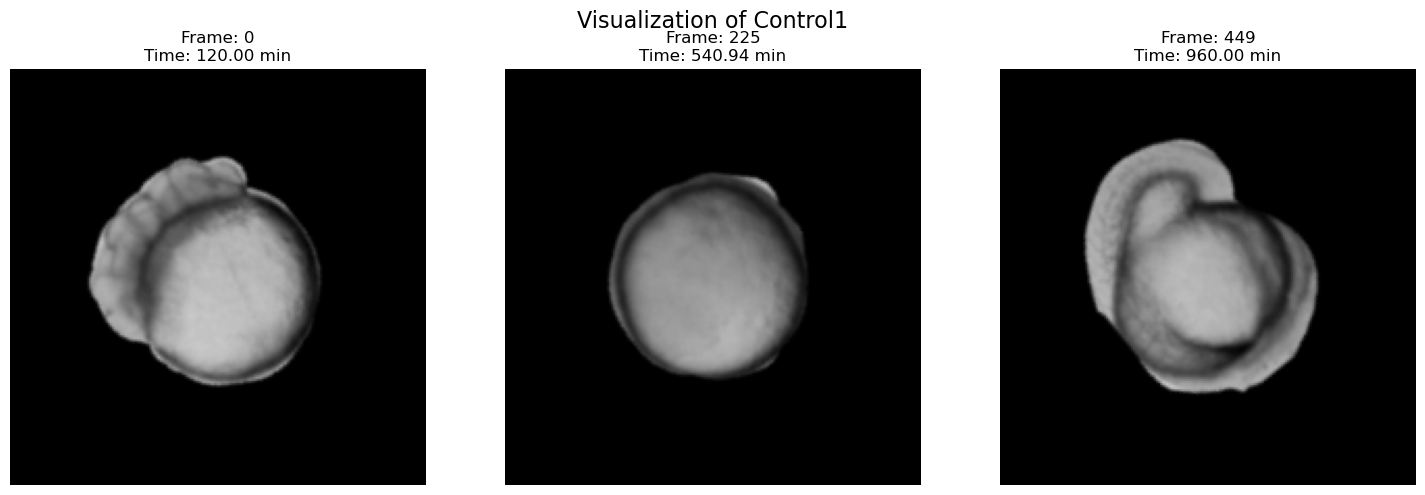

In [8]:
# Plotting the data
data_module.visualize_embryo('Control1')

### 3. Creating Sequences and DataLoaders

We call the `.prepare_dataloaders()` method. This takes the target embryo stack, slices it into `(n_past, n_future)` sequences, performs the 80/20 temporal split, and creates the PyTorch `DataLoader` objects. Then, we verify the dataloaders.

In [9]:
# Create Dataloader
data_module.prepare_dataloaders(
    target_embryo=TARGET_EMBRYO,
    n_past=N_PAST,
    n_future=N_FUTURE,
    train_split_percent=TRAIN_SPLIT_PERCENT,
    batch_size=BATCH_SIZE
)

Total sequences created: 440
Training sequences: 352 (80.0 %)
Validation sequences: 88 (20.0 %)
x_train tensor shape: torch.Size([352, 10, 1, 200, 200])
y_train tensor shape: torch.Size([352, 1, 200, 200])
x_val tensor shape: torch.Size([88, 10, 1, 200, 200])
y_val tensor shape: torch.Size([88, 1, 200, 200])
DataLoaders created with batch_size=2.


In [10]:
if data_module.train_loader:
    print(f"Train loader: {len(data_module.train_loader)} batches")
    print(f"Val loader: {len(data_module.val_loader)} batches")
    
    # Single batch
    X_batch, y_batch = next(iter(data_module.train_loader)) #1st
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")

Train loader: 176 batches
Val loader: 44 batches
X_batch shape: torch.Size([2, 10, 1, 200, 200])
y_batch shape: torch.Size([2, 1, 200, 200])


### 4. Define Model, Loss, and Optimizer

We set the architecture's hyperparameters (hidden channels, layers). We then instantiate our `Forecaster` model.

In [11]:
# Model Hyperparameters 
IN_CHANNELS = 1      # 1 channel (grayscale)
KERNEL_SIZE = (3, 3) # 3x3 kernel
HIDDEN_DIMS = [32, 64]
NUM_LAYERS = 2

# Forecaster class 
model = Forecaster(
    input_dim=IN_CHANNELS,
    hidden_dims=HIDDEN_DIMS,
    kernel_size=KERNEL_SIZE,
    num_layers=NUM_LAYERS
)

# Move the model to the GPU (device)
model.to(device)

# Loss Function
def loss_fn(y_pred, y_true):
    """
    SSIM-based loss function.
    """
    # data_range=1.0, normalized
    return 1 - ssim(y_pred, y_true, data_range=1.0, size_average=True)
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model:
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print("\n Model Architecture ")
print(model)

Total trainable parameters: 260,161

 Model Architecture 
Forecaster(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (final_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### 5. Run Training

We instantiate our `Trainer` class. We then call the `.train()` method to start the training loop for the specified `NUM_EPOCHS`.

In [12]:
# Training Parameters
NUM_EPOCHS = 50 

# Define the Trainer
trainer = Trainer(
    model=model,
    train_loader=data_module.train_loader,
    val_loader=data_module.val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device
)

# Run the training
trainer.train(num_epochs=NUM_EPOCHS)

Trainer initialized.
Device: cuda
Starting training for 50 epochs...
Epoch [01/50] - Time: 52.79s - Train Loss: 0.19112376 - Val Loss: 0.10907755
Epoch [02/50] - Time: 53.21s - Train Loss: 0.08011832 - Val Loss: 0.10257040
Epoch [03/50] - Time: 52.49s - Train Loss: 0.07909660 - Val Loss: 0.10224418
Epoch [04/50] - Time: 52.43s - Train Loss: 0.07896009 - Val Loss: 0.10232394
Epoch [05/50] - Time: 52.67s - Train Loss: 0.07847575 - Val Loss: 0.10290526
Epoch [06/50] - Time: 53.55s - Train Loss: 0.07801965 - Val Loss: 0.10222301
Epoch [07/50] - Time: 52.74s - Train Loss: 0.07766502 - Val Loss: 0.10194492
Epoch [08/50] - Time: 52.64s - Train Loss: 0.07728430 - Val Loss: 0.10121910
Epoch [09/50] - Time: 53.25s - Train Loss: 0.07733968 - Val Loss: 0.10327728
Epoch [10/50] - Time: 52.53s - Train Loss: 0.07709197 - Val Loss: 0.10123834
Epoch [11/50] - Time: 52.58s - Train Loss: 0.07671568 - Val Loss: 0.10132848
Epoch [12/50] - Time: 52.67s - Train Loss: 0.07580081 - Val Loss: 0.10076809
Epoch [

### 6. Plotting Loss Curves

We plot both curves to analyze the model's performance.

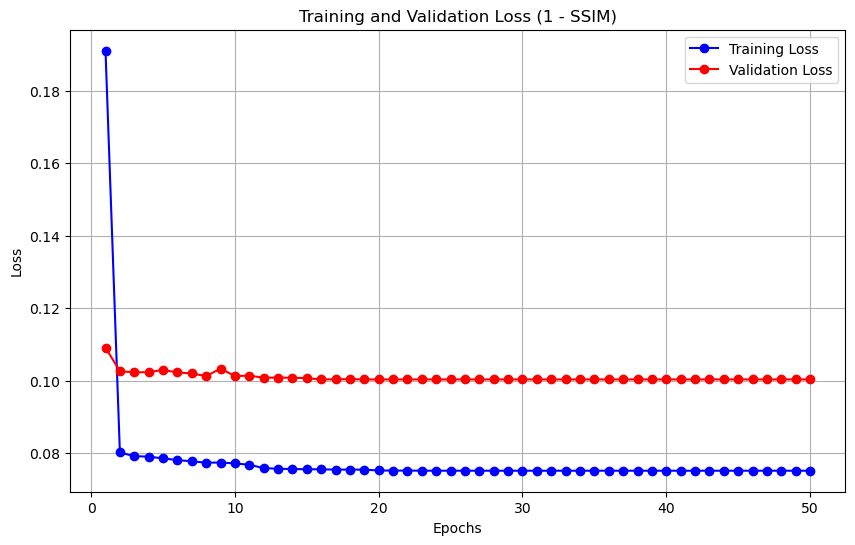

In [13]:
# Get the loss history from the trainer object
train_loss_history = trainer.train_losses
val_loss_history = trainer.val_losses

# Get the number of epochs
epochs = range(1, len(train_loss_history) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_history, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss (1 - SSIM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 7. Qualitative Evaluation of Predictions

 For the last batch inside the validation set, we plot an input vs. ground truth vs. prediction comparison to see how well the model learned.

Getting the last batch from val_loader...


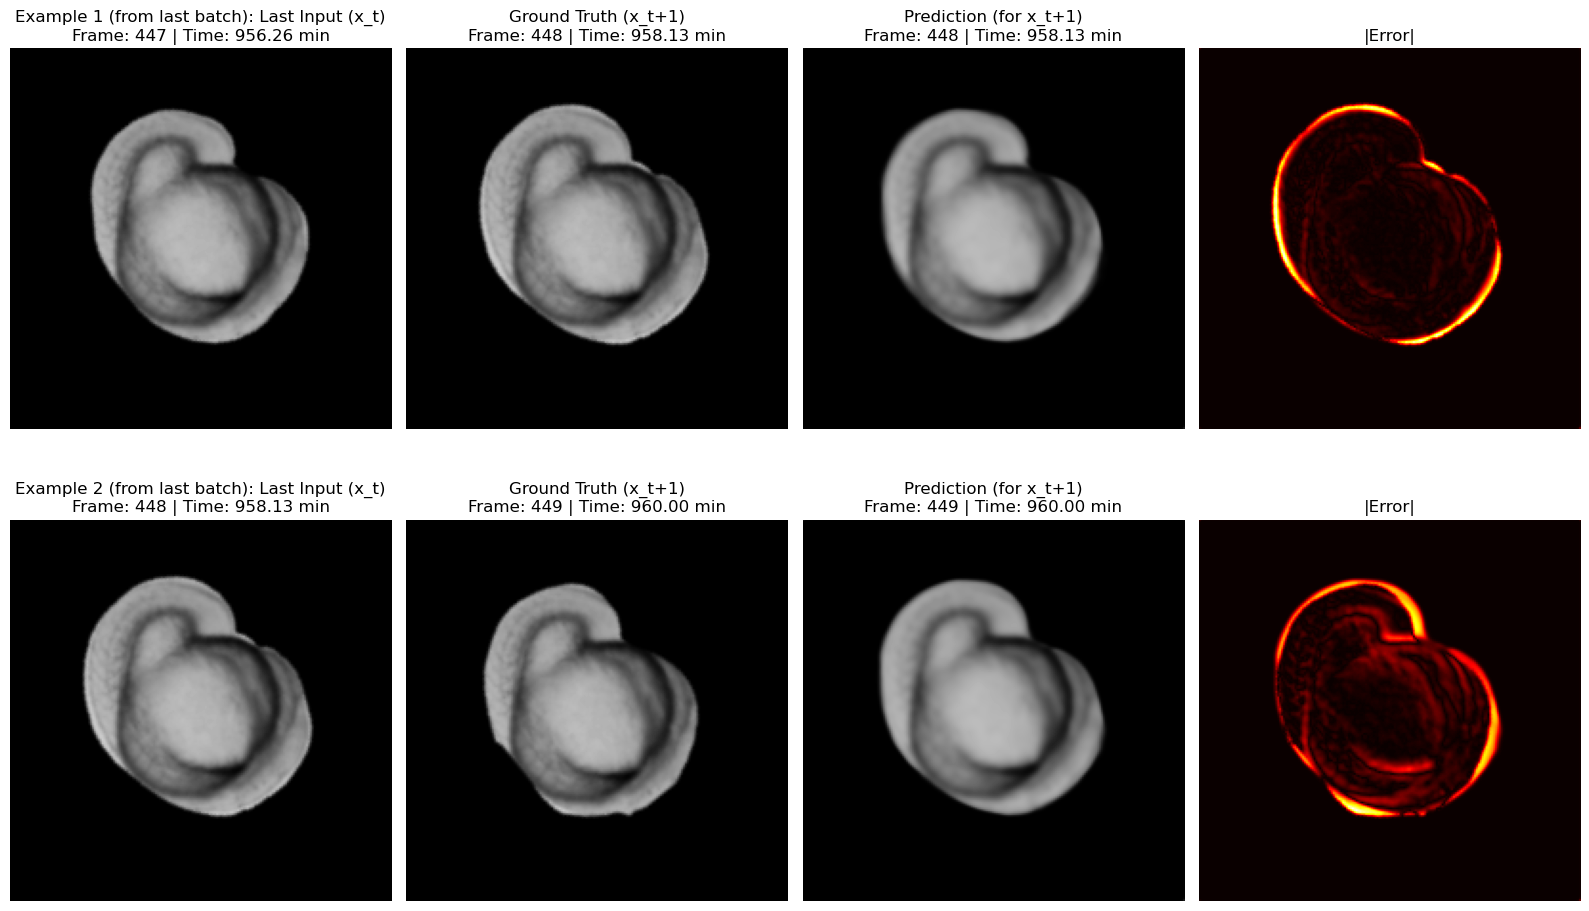

In [15]:
model.eval()

# Last batch
print("Getting the last batch from val_loader...")
for batch in data_module.val_loader:
    Xb, yb = batch

if Xb is not None and yb is not None:
    # Move the batch to the device
    Xb = Xb.to(device)
    yb = yb.to(device)
    
    # Make predictions
    with torch.no_grad():
        y_pred = model(Xb)
    
    # Move tensors to CPU for plotting
    Xb_cpu = Xb.cpu().numpy()
    yb_cpu = yb.cpu().numpy()
    y_pred_cpu = y_pred.cpu().numpy()
    
    # Get info needed for timestamps
    
    # Full timestamp array for the target embryo
    all_timestamps = data_module.metadata_timestamps[data_module.target_embryo]
    
    # Recalculate where the validation set starts
    target_stack = data_module.normalized_data[data_module.target_embryo]
    total_frames = len(target_stack)
    total_samples = total_frames - data_module.n_past - data_module.n_future + 1
    val_start_index = int(total_samples * data_module.train_split_percent)
    
    # Get n_past (e.g., 10)
    n_past = data_module.n_past
    
    # batch size
    last_batch_size = Xb.shape[0]
    
    # Number of validation
    total_val_samples = total_samples - val_start_index
    
    batch_start_index_in_val_dataset = total_val_samples - last_batch_size
    
    
    # Plotting
    
    #Last batch
    n_examples_to_show = last_batch_size 
    
    plt.figure(figsize=(16, 5 * n_examples_to_show))    
    
    for i in range(n_examples_to_show):
        # Get the frame data
        last_input_frame = Xb_cpu[i, -1, 0, :, :] 
        ground_truth_frame = yb_cpu[i, 0, :, :]
        predicted_frame = y_pred_cpu[i, 0, :, :]
        error_map = np.abs(predicted_frame - ground_truth_frame)
        
        # 'batch_start_index_in_val_dataset' es dónde empieza este batch (ej. 86)
        val_dataset_index = batch_start_index_in_val_dataset + i
        
        # 'val_start_index' es dónde empieza el val_dataset completo (ej. 352)
        sequence_index = val_start_index + val_dataset_index
        
        last_input_frame_idx = sequence_index + n_past - 1
        target_frame_idx = last_input_frame_idx + 1
        
        # Get the actual timestamps from our metadata array
        time_t = all_timestamps[last_input_frame_idx]
        time_t_plus_1 = all_timestamps[target_frame_idx]
        
        # Last Input
        ax = plt.subplot(n_examples_to_show, 4, i*4 + 1)
        ax.imshow(last_input_frame, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Example {i+1} (from last batch): Last Input (x_t)\nFrame: {last_input_frame_idx} | Time: {time_t:.2f} min")
        ax.axis('off')
        
        # Ground Truth 
        ax = plt.subplot(n_examples_to_show, 4, i*4 + 2)
        ax.imshow(ground_truth_frame, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Ground Truth (x_t+1)\nFrame: {target_frame_idx} | Time: {time_t_plus_1:.2f} min")
        ax.axis('off')
        
        # Prediction 
        ax = plt.subplot(n_examples_to_show, 4, i*4 + 3)
        ax.imshow(predicted_frame, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Prediction (for x_t+1)\nFrame: {target_frame_idx} | Time: {time_t_plus_1:.2f} min")
        ax.axis('off')
        
        # Error Map
        ax = plt.subplot(n_examples_to_show, 4, i*4 + 4)
        ax.imshow(error_map, cmap='hot', vmin=0, vmax=error_map.max())
        ax.set_title(f"|Error|")
        ax.axis('off')

    plt.tight_layout()
    plt.show()